# Summarising the variance

For this example we are going use the LFI module to infer the unknown variance, $\Sigma$, of $n_{\bf d}=10$ data points of a 1D random zero-mean Gaussian field, ${\bf d}=\{d_i\sim\mathcal{N}(0,\Sigma)|i\in[1, n_{\bf d}]\}$. This is an interesting problem since we know the likelihood analytically, but it is non-Gaussian
$$\mathcal{L}({\bf d}|\Sigma) = \prod_i^{n_{\bf d}}\frac{1}{\sqrt{2\pi|\Sigma|}}\exp\left[-\frac{1}{2}\frac{d_i^2}{\Sigma}\right]$$

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import tensorflow as tf
import IMNN
from IMNN.LFI import LFI
from make_data import GenerateGaussianNoise
from make_data import AnalyticLikelihood
import tensorflow_probability as tfp
tfd = tfp.distributions

print("IMNN {}\nTensorFlow {}\nTensorFlow Probability {}\nnumpy {}\nmatplotlib {}".format(
    IMNN.__version__, tf.__version__, tfp.__version__, np.__version__, mpl.__version__))

/Users/tomcharnock/.pyenv/versions/3.7.9/lib/python3.7/site-packages/pandas/compat/__init__.py:120: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


IMNN 0.2dev
TensorFlow 2.3.0
TensorFlow Probability 0.11.0
numpy 1.18.5
matplotlib 3.3.1



Lets observe some data generated from a Gaussian distribution with a variance $\Sigma=2$ - we're going to generate the data from seed 37 (for no particular reason). Once this is generated we're going to forget that we ever knew this. Simulations from this model can be made using

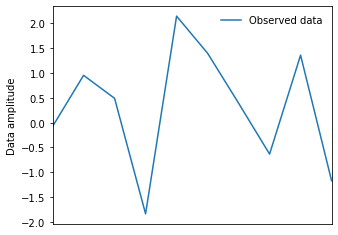

In [2]:
generator = GenerateGaussianNoise(n_params=1)

θ_target = np.array([2])[np.newaxis, :]
target_data = generator.simulator(
    parameters=θ_target,
    seed=37,
    simulator_args={"input_shape": generator.input_shape})

generator.plot_data(target_data, label="Observed data")

## Inferring the mean and variance

In the `AnalyticLikelihood` module we have routines for calculating the exact likelihood for this problem.

For the inference we start by defining our prior as a uniform distribution. This distribution can be a TensorFlow Probability distribution for simplicity. We are going to choose the prior to be uniform from 0.1 to 10.

$$p(\mu,\Sigma)=\textrm{Uniform}\left[\textrm{lower}=0.1,\textrm{upper}=10\right]$$

Because we want an event size of at least `[1]` then we'll wrap the uniform in a blockwise wrapper.

In [3]:
prior = tfd.Blockwise([tfd.Uniform(0.1, 10.)])

In [4]:
AL = AnalyticLikelihood(
    parameters=1,
    data=target_data, 
    prior=prior, 
    generator=generator,
    labels=[r"$\Sigma$"])

As well as knowing the likelihood for this problem, we also know what sufficient statistics describe the variance of the data - it's the variance
$$\frac{1}{n_{\bf d}-1}\sum_i^{n_{\bf d}}(d_i-\mu)^2=\Sigma$$
What makes this an interesting problem for the IMNN is the fact that the sufficient statistic for the variance is non-linear, i.e. it is a sum of the square of the data, and so linear methods like MOPED would be lossy in terms of information.

We can calculate the statistics of observed data (generated from a Gaussian distribution with a variance of $\Sigma=2$)

In [5]:
print("Variance of observed data = {}".format(
    AL.get_estimate(target_data)))

Variance of observed data = [[1.397]]


We might want to know how likely it is that any particular parameters of the Gaussian model are given that we have observed this data. This is given by the posterior distribution
$$\mathcal{P}(\Sigma|{\bf d})\propto\mathcal{L}({\bf d}|\Sigma)p(\Sigma)$$

For example, let's say we want to know how likely it is that this data came from a model with some fiducial parameter $\Sigma^\textrm{fid}=1$.

In [6]:
θ_fid = np.array([1.])

We can evaluate the analytic likelihood, weighted by the prior

In [7]:
print("log P(Σ=1|d) ∝ {}".format(
    AL.log_posterior(grid=θ_fid)))

log P(Σ=1|d) ∝ [-18.925]


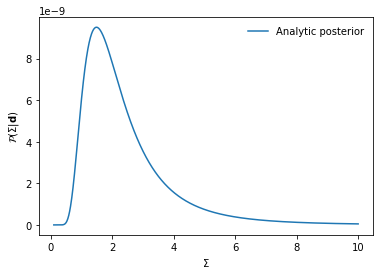

In [8]:
Σ = np.linspace(0.1, 10, 1000)[np.newaxis]
plt.plot(Σ[0], AL.posterior(Σ)[0], color="C0", 
         label="Analytic posterior")
plt.legend(frameon=False)
plt.xlabel(r"$\Sigma$")
plt.ylabel(r"$\mathcal{P}(\Sigma|{\bf d})$");

In the `LFI` submodule there are a handful of functions which allow us to do likelihood-free inference (LFI). The first order approximation is the Gaussian approximation to the likelihood.

In [9]:
GA = LFI.GaussianApproximation(
    target_data=target_data, 
    prior=prior, 
    Fisher=AL.Fisher(θ_fid),
    get_estimate=AL.get_estimate,
    labels=[r"$\Sigma$"])

We can calculate the Fisher information by taking the negative second derivative of the likelihood taking the expectation by inserting the relations for the sufficient statistics and examining at the fiducial parameter values
$${\bf F}_{\alpha\beta} = -\left.\left(\begin{array}{cc}\displaystyle-\frac{n_{\bf d}}{2\Sigma^2}\end{array}\right)\right|_{\textrm{fiducial}}.$$

The inverse Fisher information describes the Cramer-Rao bound, i.e. the minimum variance of a Gaussian approximation of the likelihood about the fiducial parameter values. We can therefore use the Fisher information to make an approximation to posterior. The inverse Fisher can be view using

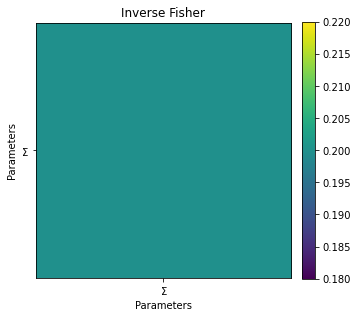

In [10]:
GA.plot_Fisher(figsize=(5, 5));

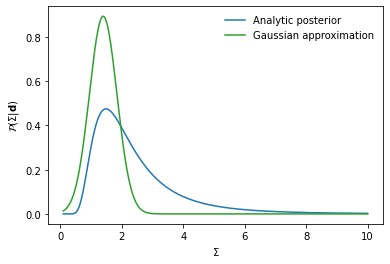

In [11]:
plt.plot(Σ[0], AL.posterior(Σ)[0] / np.sum(AL.posterior(Σ)[0] * (Σ[0][1] - Σ[0][0])), 
         color="C0", label="Analytic posterior")
plt.plot(Σ[0], GA.posterior(Σ)[0]/ np.sum(GA.posterior(Σ)[0] * (Σ[0][1] - Σ[0][0])), 
         color="C2", label="Gaussian approximation")
plt.legend(frameon=False)
plt.xlabel(r"$\Sigma$")
plt.ylabel(r"$\mathcal{P}(\Sigma|{\bf d})$");

Note that we are renormalising the posterior here because the Gaussian drops below zero, but is not truncated.

## Approximate Bayesian computation
We can also do approximate Bayesian computation using the mean and variance as sufficient statistics describing the data. The ABC draws parameter values from the prior and makes simulations at these points. These simulations are then summarised, i.e. we find the mean and variance of the simulations in this case, and then the distance between these estimates and the estimate of the target data can be calculated. Estimates within some small ϵ-ball around the target estimate are approximately samples from the posterior. Note that the larger the value of ϵ, the worse the approximation to the posterior. 

In [12]:
ABC = LFI.ApproximateBayesianComputation(
    target_data=target_data, 
    prior=prior, 
    Fisher=AL.Fisher(θ_fid),
    get_estimate=AL.get_estimate,
    simulator=lambda x : generator.simulator(
        x, None, {"input_shape": generator.input_shape}),
    labels=[r"$\Sigma$"])

We can call the ABC directly, for (say) 100000 draws using
```python
ABC(draws=100000, at_once=True, save_sims="simulations/sims")
```
This triggers the production of `draws=100000` simulations with parameters sampled from the prior. By default, `at_once=True` and so the simulations are returned at once and processed parallelly - if the estimator cannot deal with the all the simulations in parallel then we need to set `at_once=False`. All of the simulations will be saved in a `simulations` directory (which should be premade) under the same `sims`. If you don't want to save the simulations then `save_sims=None` is default. The `ABC()` call returns parameters, estimates, differences from the target and distances from the target, but they are also available as attributes
```python
ABC.parameters
  #(100000, 1)
ABC.estimates 
  #(100000, 1)
ABC.differences
  #(100000, 1, 1)
ABC.distances
  #(100000, 1)
```

This runs the ABC, but doesn't define the accepted or rejected samples. To run the acceptance and rejection within a distance of `ϵ=1` we can run
```python
ABC.accept_reject(ϵ=1)
```
This makes available the accepted and rejected parameters, and statistics
```python
ABC.num_draws
  # () = 100000
ABC.num_accepted
  # (1) = 12756
ABC.num_rejected
  # (1) = 87244
ABC.accepted_parameters
  # (1, 12756, 1)
ABC.accepted_estimates
  # (1, 12756, 1)
ABC.accepted_differences
  # (1, 12756, 1)
ABC.accepted_distances
  # (1, 12756)
ABC.rejected_parameters
  # (1, 87244, 1)
ABC.rejected_estimates
  # (1, 87244, 1)
ABC.rejected_differences
  # (1, 87244, 1)
ABC.rejected_distances
  # (1, 87244)
```

If we want to continue the ABC we can just call it again. However it can be useful to have a known number of samples (say `accepted=2000` samples) within a chosen ϵ-ball (say `ϵ=1`). This will iteratively run the ABC until 2000 samples are within an ϵ of 1 of the target. We can do as many or as few simulations at once as we like. In our case we will use `min_draws=10000`. We can use the same `ABC` arguments (`at_once` and `save_sims`) to process the simulations sequentially or not and to save the simulations. This method is run using
```python
ABC.get_min_accepted(ϵ=1, accepted=2000, min_draws=10000)
```
The posterior can then be obtained (as a histogram) using
```python
ABC.posterior()
```
where the number of `bins` and `ranges` can be passed if necessary. Note that we can also pass `ϵ`, `accepted`, `draws` (`draws` takes the place of `min_draws` if `accepted` is not `None`) and any of the other arguments directely to `ABC.posterior()`, so that the posterior is calculated without needing to run `ABC()`, `ABC.accept_reject()` or `ABC.get_min_accepted()` first.

The ABC can be reset back to default by running
```python
ABC.reset()
```

It is also possible to run the ABC with saved simulations. To do so imagine we have an array of parameter values `saved_parameters` with shape `saved_parameters.shape -> (100000, 2)` and corresponding simulations `saved_simulations` with shape `saved_simulations.shape -> (100000, 10)` (correctly aligned with `saved_parameters`, then we can call
```python
ABC = LFI.ApproximateBayesianComputation(
    target_data=target_data, 
    prior=prior, 
    Fisher=AL.Fisher(θ_fid),
    get_estimate=AL.get_estimate,
    simulator=lambda _ : saved_simulations)
ABC(draws=saved_parameters, predrawn=True)
ABC.accept_reject(ϵ=1.)

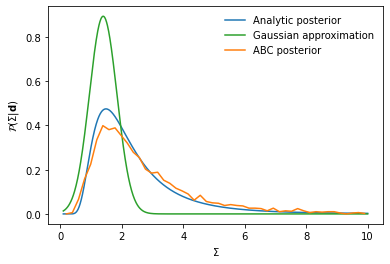

In [13]:
plt.plot(Σ[0], AL.posterior(Σ)[0] / np.sum(AL.posterior(Σ)[0] * (Σ[0][1] - Σ[0][0])), 
         color="C0", label="Analytic posterior")
plt.plot(Σ[0], GA.posterior(Σ)[0]/ np.sum(GA.posterior(Σ)[0] * (Σ[0][1] - Σ[0][0])), 
         color="C2", label="Gaussian approximation")
ABC_posterior = ABC.posterior(ϵ=1., accepted=2000, draws=10000, bins=50)
plt.plot(ABC.grid[0], ABC_posterior[0],
         color="C1", label="ABC posterior")
plt.legend(frameon=False)
plt.xlabel(r"$\Sigma$")
plt.ylabel(r"$\mathcal{P}(\Sigma|{\bf d})$");

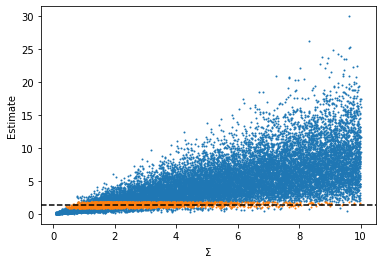

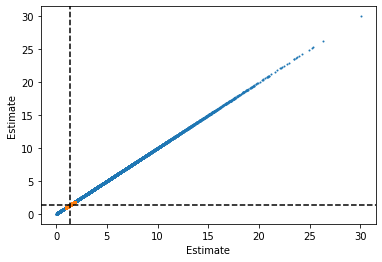

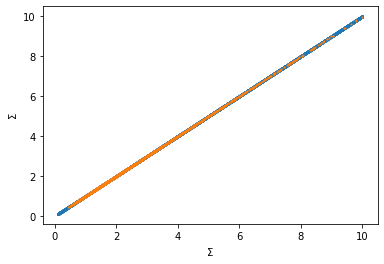

In [14]:
plt.figure()
plt.scatter(ABC.rejected_parameters[::10], ABC.rejected_estimates[::10], 
            s=1, label="Rejected samples")
plt.scatter(ABC.accepted_parameters, ABC.accepted_estimates, 
            s=1, label="Accepted samples")
plt.axhline(ABC.estimate, linestyle="dashed", color="black")
plt.xlabel(r"$\Sigma$")
plt.ylabel("Estimate")

plt.figure()
plt.scatter(ABC.rejected_estimates[::10], ABC.rejected_estimates[::10], 
            s=1, label="Rejected samples")
plt.scatter(ABC.accepted_estimates, ABC.accepted_estimates, 
            s=1, label="Accepted samples")
plt.axhline(ABC.estimate, linestyle="dashed", color="black")
plt.axvline(ABC.estimate, linestyle="dashed", color="black")
plt.xlabel("Estimate")
plt.ylabel("Estimate")

plt.figure()
plt.scatter(ABC.rejected_parameters[::10], ABC.rejected_parameters[::10], 
            s=1, label="Rejected samples")
plt.scatter(ABC.accepted_parameters, ABC.accepted_parameters, 
            s=1, label="Accepted samples")
plt.xlabel(r"$\Sigma$")
plt.ylabel(r"$\Sigma$");

## Population Monte Carlo

Whilst we can obtain approximate posteriors using ABC, the rejection rate is very high because we sample always from the prior. Population Monte Carlo (PMC) uses statistics of the population of samples to propose new parameter values, so each new simulation is more likely to be accepted. This prevents us needing to define an ϵ parameter to define the acceptance distance. Instead we start with a population from the prior and iteratively move samples inwards. Once it becomes difficult to move the population any more, i.e. the number of attempts to accept a parameter becomes very large, then the distribution is seen to be a stable approximation to the posterior.

The whole module works very similarly to `ABC` with a few changes in arguments.

In [15]:
PMC = LFI.PopulationMonteCarlo(
    target_data=target_data, 
    prior=prior, 
    Fisher=AL.Fisher(θ_fid),
    get_estimate=AL.get_estimate,
    simulator=lambda x : generator.simulator(
        x, None, {"input_shape": generator.input_shape}),
    labels=[r"$\Sigma$"])

We can call the PMC directly for a population of 2000 samples using
```python
PMC(draws=2000, initial_draws=5000, criterion=0.1, percentile=75, at_once=True, save_sims="simulations/sims")
```
This performs ABC on 5000 samples, and selects a population from the 2000 samples closest to the target. This population is then moved towards the target until it takes 10 times as many simulations to be rejected as are accepted. We chose to move the outer 25% of samples all at once, rather than just the furthest simulation at a time, i.e. the stable population is defined by the 75th percentile. This can be more efficient for some distributions and less efficient for others. Setting `percentile=None` moves only the furthest sample.

Similar to the ABC, by default, `at_once=True` and so the simulations are returned at once and processed parallelly - if the estimator cannot deal with the all the simulations in parallel then we need to set `at_once=False`. All of the simulations will be saved in a `simulations` directory (which should be premade) under the same `sims`. If you don't want to save the simulations then `save_sims=None` is default. The saving is not yet tested for the PMC. The `PMC()` call returns parameters, estimates, differences from the target and distances from the target, but they are also available as attributes
```python
PMC.parameters
  #(1, 2000, 1)
PMC.estimates 
  #(1, 2000, 1)
PMC.differences
  #(1, 2000, 1)
PMC.distances
  #(1, 2000)
PMC.num_draws
  #(1) = 95721
```
Note that here `PMC.num_draws` does not include the `initial_draws`.

The posterior can then be obtained (as a histogram) using
```python
PMC.posterior()
```
where the number of `bins` and `ranges` can be passed if necessary. Note that we can also pass `draws`, `initial_draws`, `criterion` and `percentile` and any of the other arguments directely to `PMC.posterior()`, so that the posterior is calculated without needing to run `PMC()` first.

The PMC can be reset back to default by running
```python
PMC.reset()
```

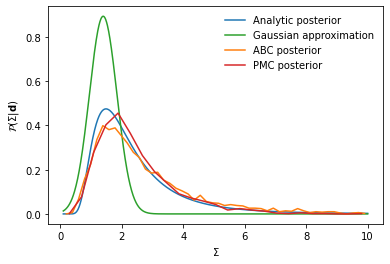

In [16]:
plt.plot(Σ[0], AL.posterior(Σ)[0] / np.sum(AL.posterior(Σ)[0] * (Σ[0][1] - Σ[0][0])), 
         color="C0", label="Analytic posterior")
plt.plot(Σ[0], GA.posterior(Σ)[0]/ np.sum(GA.posterior(Σ)[0] * (Σ[0][1] - Σ[0][0])), 
         color="C2", label="Gaussian approximation")
plt.plot(ABC.grid[0], ABC_posterior[0],
         color="C1", label="ABC posterior")
PMC_posterior = PMC.posterior(draws=2000, initial_draws=5000, 
                          criterion=0.1, percentile=75)
plt.plot(PMC.grid[0], PMC_posterior[0],
         color="C3", label="PMC posterior")
plt.legend(frameon=False)
plt.xlabel(r"$\Sigma$")
plt.ylabel(r"$\mathcal{P}(\Sigma|{\bf d})$");

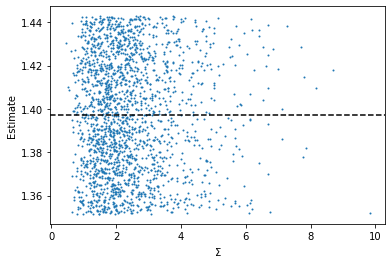

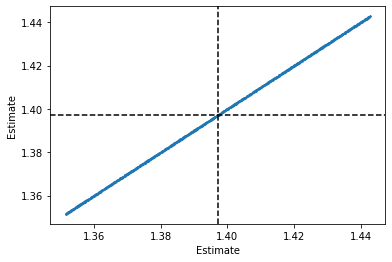

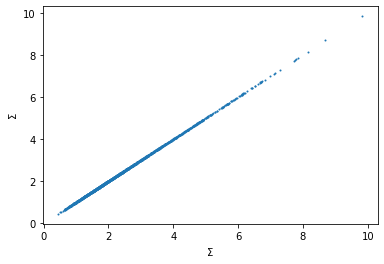

In [17]:
plt.figure()
plt.scatter(PMC.accepted_parameters, PMC.accepted_estimates, 
            s=1, label="Accepted samples")
plt.axhline(PMC.estimate, linestyle="dashed", color="black")
plt.xlabel(r"$\Sigma$")
plt.ylabel("Estimate")

plt.figure()
plt.scatter(PMC.accepted_estimates, PMC.accepted_estimates, 
            s=1, label="Accepted samples")
plt.axhline(PMC.estimate, linestyle="dashed", color="black")
plt.axvline(PMC.estimate, linestyle="dashed", color="black")
plt.xlabel("Estimate")
plt.ylabel("Estimate")

plt.figure()
plt.scatter(PMC.accepted_parameters, PMC.accepted_parameters, 
            s=1, label="Accepted samples")
plt.xlabel(r"$\Sigma$")
plt.ylabel(r"$\Sigma$");